In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
sns.set_theme(style="darkgrid")

In [58]:
path = "NVDA.csv"
df = pd.read_csv(path)

df.isna().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.509998,67867200.0
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.668188,12762000.0
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.538759,8580000.0
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.533965,6109200.0
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.529172,5688000.0


In [6]:
close = df['Close'].values
close = close[close != 0]
close = pd.Series(close)

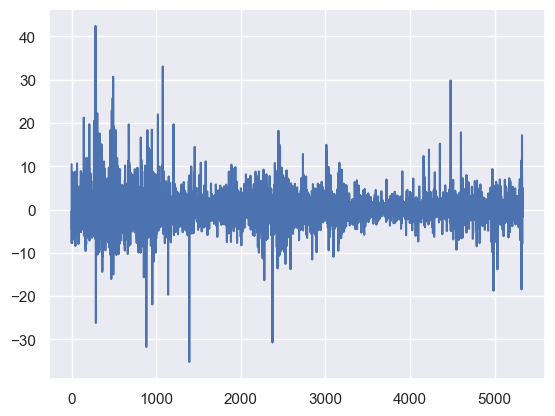

In [55]:
def get_stock_returns(data):
    stock_returns = []
    for i in range(1, len(data)):
        yesterday_stock = data[i - 1]
        today_stock = data[i]
        stock_difference = today_stock - yesterday_stock
        
        return_stock = (stock_difference/ yesterday_stock) * 100

        stock_returns.append(return_stock)

    
    return pd.Series(stock_returns)

returns = get_stock_returns(close)
plt.plot(returns)

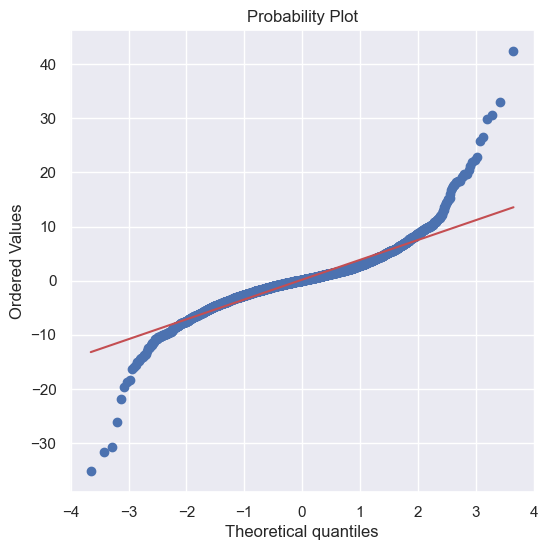

In [12]:
plt.figure(figsize=(6, 6))
stats.probplot(returns, dist="norm", plot=plt)
plt.show()

<Axes: >

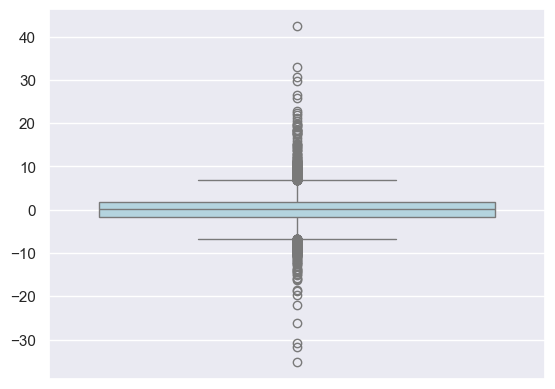

In [13]:
sns.boxplot(returns, color='lightblue')

In [ ]:
ma_7 = returns.rolling(window=7).mean()
ma_30 = returns.rolling(window=30).mean()

ma_7.shape, ma_30.shape, returns.shape

((5332,), (5332,), (5332,))

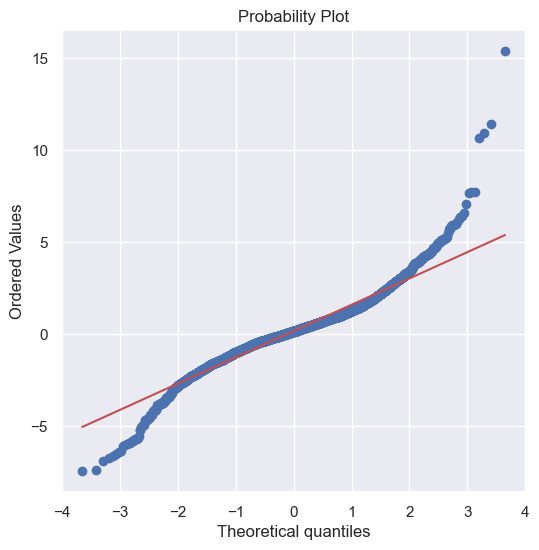

In [ ]:
plt.figure(figsize=(6, 6))
# starting from 6 as pandas.rolling adds NaN values to first window_size - 1 values 
stats.probplot(ma_7[6:], dist="norm", plot=plt)
plt.show()

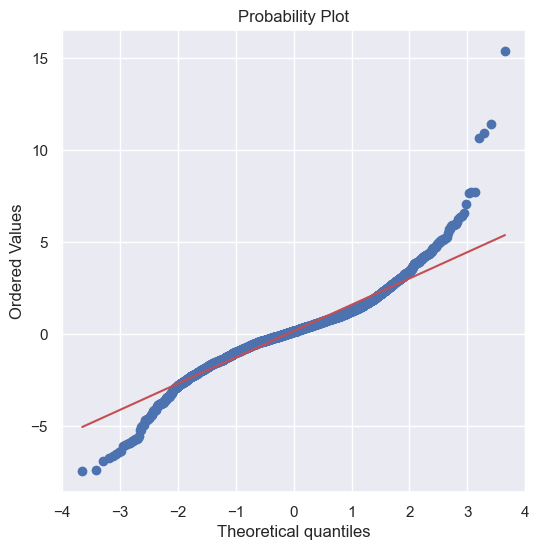

In [16]:
plt.figure(figsize=(6, 6))
stats.probplot(ma_7[29:], dist="norm", plot=plt)
plt.show()

<Axes: >

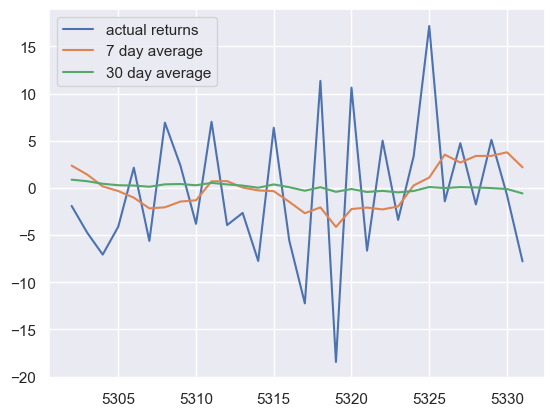

In [ ]:
sns.lineplot(returns[-30:], label= "actual returns")
sns.lineplot(ma_7[-30:], label='7 day average')
sns.lineplot(ma_30[-30:], label= '30 day average')

In [18]:
ma_7 = ma_7.dropna()
ma_30 = ma_30.dropna()

ma_7 = np.array(ma_7)
ma_30 = np.array(ma_30)
ma_7.shape, ma_30.shape

((5326,), (5303,))

In [19]:
scaler = StandardScaler()
ma_7 = scaler.fit_transform(ma_7.reshape(-1, 1))

ma_30 = scaler.fit_transform(ma_30.reshape(-1, 1))

In [20]:
def make_targets(series, window_size, target_size):
    X = []
    y = []
    for i in range(len(series) - window_size - target_size + 1):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size:i + window_size + target_size])
    
    return np.array(X), np.array(y)

X_7, y_7 = make_targets(ma_7, 7, 1)
X_30, y_30 = make_targets(ma_30, 30, 1)

X_7.shape, y_7.shape, X_30.shape, y_30.shape

((5319, 7, 1), (5319, 1, 1), (5273, 30, 1), (5273, 1, 1))

In [21]:
import torch
print(torch.__version__)

2.4.1+cpu


In [22]:
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, out_channels, p=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(in_channels=1,out_channels=out_channels,dilation=2 ,kernel_size=3)
        self.rnn = nn.LSTM(out_channels, hidden_size, num_layers)
        self.reg = nn.Dropout(p)
        self.activation = nn.ReLU()
    
    def forward(self, encoder_input):
        encoder_input = encoder_input.permute(1, 2, 0)
        conv_output  = self.cnn(encoder_input)
        reg_output = self.reg(conv_output)

        rnn_input = reg_output.permute(2, 0, 1)
        outputs, (hidden, cell) = self.rnn(rnn_input)
        
        a_hidden = self.activation(hidden)
        a_cell = self.activation(cell)

        return a_hidden, a_cell

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, p=0.3):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fully_connected = nn.Linear(hidden_size, output_size)
        self.reg = nn.Dropout(p)
        self.hidden_activation = nn.ReLU()

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        reg_output = self.reg(x)
        outputs, (hidden, cell) = self.rnn(reg_output, (hidden, cell))

        a_hidden = self.hidden_activation(hidden)
        a_cell = self.hidden_activation(cell)

        a_outputs = self.hidden_activation(outputs)
        predictions = self.fully_connected(a_outputs)


        return predictions.squeeze(1), (hidden, cell)


In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target_length):
        batch_size = source.shape[1]
        hidden, cell = self.encoder(source)
        
        decoder_input = torch.zeros(batch_size, self.decoder.fully_connected.out_features)  

        outputs = []
        for _ in range(target_length):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, hidden, cell)
            outputs.append(decoder_output)
            decoder_input = decoder_output
        
        return torch.stack(outputs, dim=0)


In [24]:
import torch.optim as optim
input_size = 1
hidden_size = 64
out_channels = 28
num_layers = 4
output_size = 1
seq_length = 7
target_length = 1

torch.manual_seed(45)

encoder = Encoder(hidden_size=hidden_size, num_layers=num_layers, out_channels=out_channels ,p=0.5)
decoder = Decoder(input_size, hidden_size, num_layers, output_size, p=0.5)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1E-4)
criterion = nn.MSELoss()


train_size = int(len(X_7) * 0.9)
X_train = X_7[:train_size]
y_train = y_7[:train_size]

val_size = int(len(X_7) * 0.05)
X_val = X_7[train_size:train_size + val_size]
y_val = y_7[train_size:train_size + val_size]


losses = []
val_losses = []
for epoch in range(200):
    optimizer.zero_grad()
    source = torch.tensor(X_train.transpose(1, 0, 2), dtype=torch.float32)
    
    target = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    
    output = model(source, target_length)
    output = output.view(-1, 1)
    
    train_loss = criterion(output, target)
    train_loss.backward()
    optimizer.step()
    losses.append(train_loss.item())

    model.eval()
    with torch.no_grad():
        val_preds = model(torch.tensor(X_val, dtype=torch.float32), target_length= 1)
        val_loss = criterion(val_preds, torch.tensor(y_val, dtype=torch.float32))
        val_losses.append(val_loss.item())

    print(f"Epoch - {epoch} Loss - {train_loss.item()} Val Loss: {val_loss.item()}")
    

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([265, 1, 1])) that is different to the input size (torch.Size([1, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch - 0 Loss - 1.0473347902297974 Val Loss: 0.641078531742096
Epoch - 1 Loss - 1.0463039875030518 Val Loss: 0.6371964812278748
Epoch - 2 Loss - 1.0454974174499512 Val Loss: 0.6337215304374695
Epoch - 3 Loss - 1.0447349548339844 Val Loss: 0.6304525136947632
Epoch - 4 Loss - 1.0439356565475464 Val Loss: 0.6274608373641968
Epoch - 5 Loss - 1.0430907011032104 Val Loss: 0.6247849464416504
Epoch - 6 Loss - 1.0422476530075073 Val Loss: 0.6224481463432312
Epoch - 7 Loss - 1.0411183834075928 Val Loss: 0.620439887046814
Epoch - 8 Loss - 1.039799451828003 Val Loss: 0.6188015937805176
Epoch - 9 Loss - 1.0382345914840698 Val Loss: 0.6173669695854187
Epoch - 10 Loss - 1.036293387413025 Val Loss: 0.6160687208175659
Epoch - 11 Loss - 1.0338691473007202 Val Loss: 0.6148855090141296
Epoch - 12 Loss - 1.0308582782745361 Val Loss: 0.6137988567352295
Epoch - 13 Loss - 1.0271373987197876 Val Loss: 0.6128308773040771
Epoch - 14 Loss - 1.022559404373169 Val Loss: 0.6120330691337585
Epoch - 15 Loss - 1.01700

<Axes: >

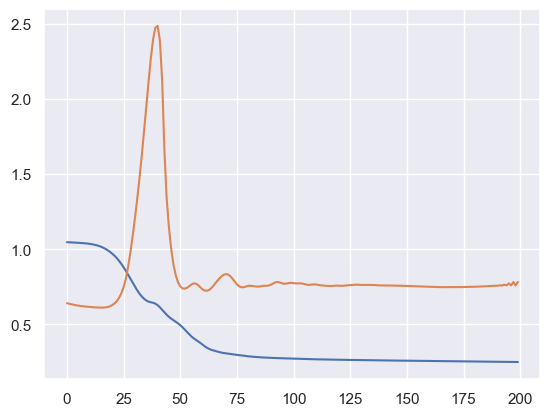

In [25]:
sns.lineplot(losses)
sns.lineplot(val_losses)


In [ ]:
model.eval()

with torch.no_grad():
    X_test = torch.tensor(X_7[-20:].transpose(1, 0, 2), dtype=torch.float32)
    y_test = torch.tensor(y_7[-20:], dtype=torch.float32).view(-1, 1)
    
    predictions = model(X_test, target_length=1)
    
preds = predictions.numpy()

mae = np.mean(np.abs(preds[0, :]- y_test.numpy()))

print(f"CNN + Seq2Seq LSTM MAE: {mae:.4f}")



    

CNN + Seq2Seq LSTM MAE: 0.5929


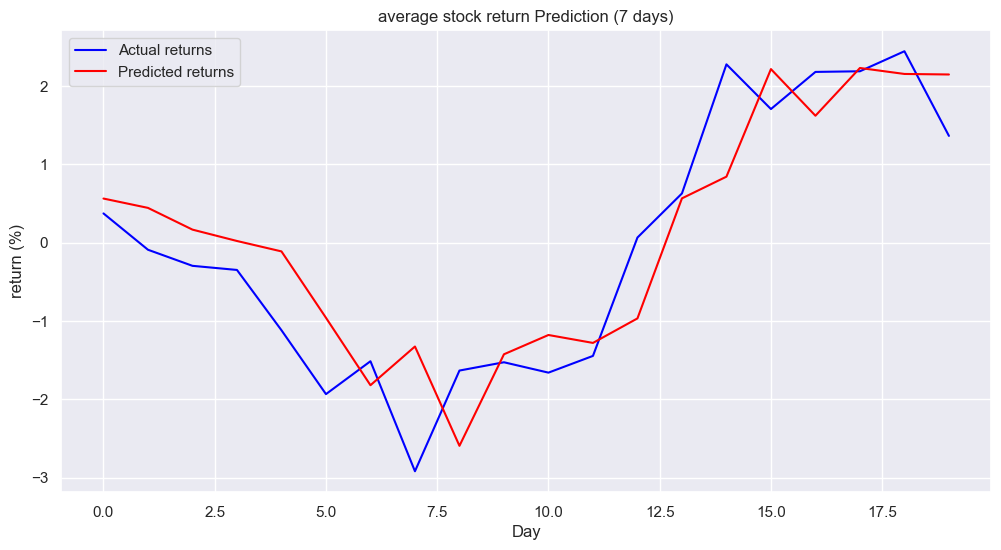

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test, color='blue', label='Actual returns')
plt.plot(preds[0, :], color='red', label='Predicted returns')
plt.title('average stock return Prediction (7 days)')
plt.xlabel('Day')
plt.ylabel('return (%)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
torch.save(model, "model1")

In [28]:
class BaseModel:
    def __init__(self, data):
        self.data = data
    
    def naive_prediction(self):
        mae = 0
        data_len = len(self.data)

        for i in range(data_len - 1):
            pred = self.data[i]
            y_actual = self.data[i + 1]

            mae += abs(y_actual - pred)
    
        mae = mae /(data_len - 1)
    
        return mae

In [29]:
naive_model = BaseModel(scaler.fit_transform(ma_7[-20:]))
print(naive_model.naive_prediction())

[0.39188877]


## Testing the model with google's stock data

<Axes: >

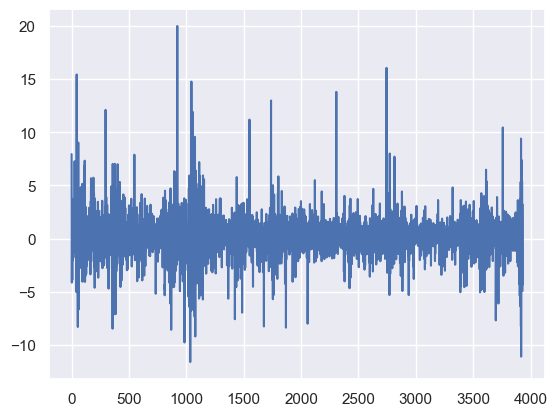

In [59]:
path = "GOOG.csv"
df = pd.read_csv(path)
df.dropna()

google_close = df['Close'].values
google_close = google_close[google_close != 0]

google_retuns = get_stock_returns(google_close)
sns.lineplot(google_retuns)

In [44]:
google_ma_7 = google_retuns.rolling(window=7).mean()
google_ma_7 = google_ma_7.dropna()
google_ma_7 = np.array(google_ma_7)
google_ma_7 = scaler.fit_transform(google_ma_7.reshape(-1, 1))

X_google, y_google = make_targets(google_ma_7, 7, 1)

In [50]:
model.eval()

with torch.no_grad():
    g_X_test = torch.tensor(X_google[-120:].transpose(1, 0, 2), dtype=torch.float32)
    g_y_test = torch.tensor(y_google[-120:], dtype=torch.float32).view(-1, 1)
    
    goolge_predictions = model(g_X_test, target_length=1)
    
goolge_preds = goolge_predictions.numpy()

goolge_preds = scaler.inverse_transform(goolge_preds[0])
y_test = scaler.inverse_transform(g_y_test)

goolge_preds.shape, g_y_test.shape

mae = 0
for i in range(len(goolge_preds)):
    diff = g_y_test[i][0] - goolge_preds[i][0]
    mae += diff

mae/ len(goolge_preds)

tensor(-0.1795)

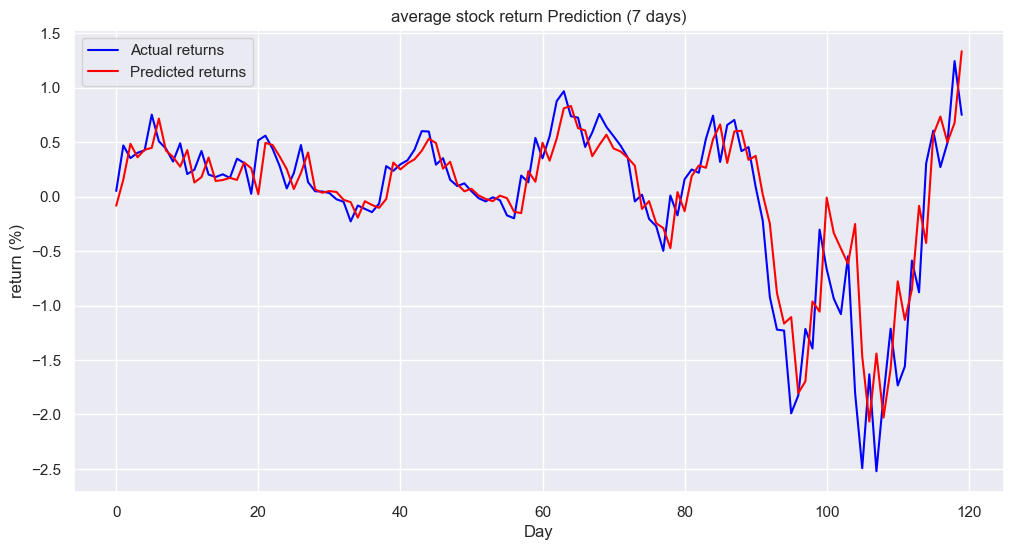

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(g_y_test), color='blue', label='Actual returns')
plt.plot(goolge_preds, color='red', label='Predicted returns')
plt.title('average stock return Prediction (7 days)')
plt.xlabel('Day')
plt.ylabel('return (%)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
google_model = BaseModel(google_ma_7[-120:])
google_model.naive_prediction()

array([0.35094311])